# Road Following by Classification - Live Demo

In this notebook, we will try to make the JetBot to follow the desired road by using the model we trained.

## Model Architecture
First we need to define a DNN model that is identical to the one used for training.

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda')

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # dropout layer
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias

## Load The Best Model
Next we need to upload the `best_model.pth` in the file browser.

Then load the parameters on the model from the `best_model.pth`.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

## Preprocessing Function

Now we create a function for preprocessing image data taken by the camera. This is very similar to what we have done in the collision avoidance example.

In [ ]:
import cv2
import numpy as np
import torchvision

mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, stdev)

def preprocess(camera_value):
    global device, normalize
    x = camera_value
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

## Camera Instance
Now we create a camera instance.

In [ ]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import Camera, bgr8_to_jpeg

camera = Camera.instance(width=224, height=224)

Then make sure your camera is working.

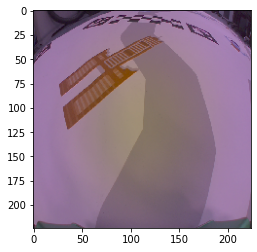

In [ ]:
import matplotlib.pyplot as plt
img = camera.value
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Robot Instance
We'll also create our robot instance which we'll need to drive the motors.

In [ ]:
from jetbot import Robot

robot = Robot()

## Define Actions
Now we create functions of move forward, turn left and turn right.

In [ ]:
def move_forward():
    robot.set_motors(0.3, 0.3)

def turn_left():
    robot.set_motors(0.1, 0.3)

def turn_right():
    robot.set_motors(0.3, 0.1)

## Run JetBot

In [ ]:
import time
t0 = time.time()

for i in range(2000):
    x = camera.value
    x = preprocess(x)
    y = model(x)
    y = nn.Softmax(dim=1)(y)
    y_idx = torch.argmax(y, dim=1).item()

    if y_idx == 0: move_forward()
    elif y_idx == 1: turn_left()
    elif y_idx == 2: turn_right()
    
    now = time.time()
    dt = now-t0
    t0 = now
    FPS = 1/dt
    print(f"\r {i} action:{y_idx} dt:{dt:.5f} fps:{FPS:.1f}", end="")

robot.stop()

 1999 action:2 dt:0.02508 fps:39.88

if you finished, stop the robot and the camera instances.

In [ ]:
robot.stop()
camera.stop()